# Pyomo Example
Pyomo lets you formulate mathematical programs which can then be solved by commercial or open-source solvers. Being a Python package, it allows optimisation problems to be constructed within a rich high-level language. Any other Python package such as Pandas, Numpy, Tensorflow, Pytorch, and Keras can be integrated within your modelling workflow.

This notebook shows you how to install Pyomo and an open-source solver, construct a model, and then solve it.

## Installing required packages
Pip is used to install Pyomo. GLPK, the open-source solver used in the following example, needs to be downloaded, extracted and then installed.

In [1]:
# Install Pyomo
! pip install pyomo

#  Install GLPK
! apt-get install manpages-dev
! apt install build-essential wget -y
! wget http://ftp.gnu.org/gnu/glpk/glpk-4.65.tar.gz
! tar -xvf glpk-4.65.tar.gz
%cd glpk-4.65
! ./configure --prefix=/usr
! make
! make check

Reading package lists... Done
Building dependency tree       
Reading state information... Done
manpages-dev is already the newest version (4.15-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
wget is already the newest version (1.19.4-1ubuntu2.2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
--2020-03-31 08:58:54--  http://ftp.gnu.org/gnu/glpk/glpk-4.65.tar.gz
Resolving ftp.gnu.org (ftp.gnu.org)... 209.51.188.20, 2001:470:142:3::b
Connecting to ftp.gnu.org (ftp.gnu.org)|209.51.188.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167110 (4.0M) [application/x-gzip]
Saving to: ‘glpk-4.65.tar.gz.1’

glpk-4.65.tar.gz.1  100%[===================>]   3.97M  2.62MB/s    in 1.5s    

2020-03-31 08:58:56 (2.62 MB/s) - ‘glpk-4.65.tar.gz.1’ saved [4167110/4167110]

glpk-4.65/


## Model components
Models constructed using algebraic modelling languages (AMLs) generally consist of six components:

1. Sets
2. Parameters
3. Variables
4. Expressions (optional)
5. Constraints
6. An objective

To demonstrate this workflow let's consider a simple economic dispatch problem. We'll first import required packages, organise some data describing generator parameters, and then construct a model using the listed components.

### Importing packages


In [0]:
# For data handling
import pandas as pd

# For constructing and solving the optimisation problem
from pyomo.environ import *

# For plotting results
import matplotlib.pyplot as plt

### Data
Let's assume we have 3 generators: $G_{1}$, $G_{2}$, and $G_{3}$. Maximum and minimum power output for each generator, along with their short-run marginal costs, are given in the DataFrame below:


In [3]:
# Generator data 
data = {
    'G_1': {'cost': 10, 'max_power': 150, 'min_power': 0}, 
    'G_2': {'cost': 20, 'max_power': 100, 'min_power': 0}, 
    'G_3': {'cost': 40, 'max_power': 50, 'min_power': 0}
        }
        
df = pd.DataFrame(data)
df

,G_1,G_2,G_3
cost,10,20,40
max_power,150,100,50
min_power,0,0,0


### Model
A simple workflow that can be applied to almost all Pyomo models is as follows:
1. Instantiate a model object;
2. define sets;
3. define variables, parameters, expressions, and constraints -- the sets defined in 2 will be helpful here
4. define an objective
5. setup a solver
6. solve the model and extract results

In the following example, the model is initialised and a set of generators is constructed. Parameters relating to generators and system demand are then defined, with generator data extracted from the DataFrame previously constructed.

The power output of each generator will constitute variables in our model. Note that one power output variable needs to be created for each generator, so we construct power output variables over the set of generators.

An expression for the total generation cost is defined: 

Total cost = $\sum\limits_{g \in \mathcal{G}} p_{g}C_{g}$.

Constraints are then defined to ensure power output for each generator is within its minimum and minimum and maximum limits:

$p_{g} \leq \overline{P}_{g}$

$p_{g} \geq \underline{P}_{g}$

A power balance constraint ensures total supply = total demand:

$\sum\limits_{g \in \mathcal{G}}p_{g} = D$

The total cost expression is then used as the model's objective. The solver is then specified -- here we've used GLPK, an open-source solver. You can also use commerical solvers like Gurobi and CPLEX -- both offer academic licenses. The model is then solved, with the solution stored within the model instance.

In [4]:
# Construct a model object
m = ConcreteModel()

# Sets
# ----
# List of generators in the network
m.GENERATORS = Set(initialize=['G_1', 'G_2', 'G_3'])


# Parameters
# ----------
# System demand (MW)
m.DEMAND = Param(initialize=100, mutable=True)

def cost_rule(m, g):
  """Short-run marginal cost ($/MWh)"""
  return df.loc['cost', g]

# Short-run marginal cost for each generator
m.COST = Param(m.GENERATORS, rule=cost_rule)


# Variables
# ---------
m.p = Var(m.GENERATORS)


# Expressions
# -----------
m.TOTAL_COST = Expression(expr=sum(m.p[g] * m.COST[g] for g in m.GENERATORS))


# Constraints
# -----------
def max_power_rule(m, g):
  """Maximum power output constraint"""
  return m.p[g] <= df.loc['max_power', g]

# Max power output by each generator
m.MAX_POWER = Constraint(m.GENERATORS, rule=max_power_rule)

def min_power_rule(m, g):
  """Minimum power output constraint"""
  return m.p[g] >= df.loc['min_power', g]

# Min power output by each generator
m.MIN_POWER = Constraint(m.GENERATORS, rule=min_power_rule)

# Power balance constraint
m.POWER_BALANCE = Constraint(expr=sum(m.p[g] for g in m.GENERATORS) == m.DEMAND)


# Objective
# ---------
m.OBJECTIVE = Objective(expr=m.TOTAL_COST, sense=minimize)


# Solver
# ------
opt = SolverFactory('glpk', solver_io='lp', executable="/content/glpk-4.65/examples/glpsol")


# Solving the model
# -----------------
results = opt.solve(m, tee=True)
results

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /tmp/tmp8gu7ptvy.glpk.raw --wglp /tmp/tmpj_0or9y_.glpk.glp --cpxlp
 /tmp/tmpl5vyzfyg.pyomo.lp
Reading problem data from '/tmp/tmpl5vyzfyg.pyomo.lp'...
8 rows, 4 columns, 10 non-zeros
48 lines were read
Writing problem data to '/tmp/tmpj_0or9y_.glpk.glp'...
39 lines were written
GLPK Simplex Optimizer, v4.65
8 rows, 4 columns, 10 non-zeros
Preprocessing...
1 row, 2 columns, 2 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 1
*     0: obj =   1.000000000e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (40400 bytes)
Writing basic solution to '/tmp/tmp8gu7ptvy.glpk.raw'...
21 lines were written


{'Problem': [{'Name': 'unknown', 'Lower bound': 1000.0, 'Upper bound': 1000.0, 'Number of objectives': 1, 'Number of constraints': 8, 'Number of variables': 4, 'Number of nonzeros': 10, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.04400491714477539}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Model results
Solving the model updates variable values associated with the model instance. The optimal solution for power output variables is shown below. It can be see that only $G_{1}$ is used to meet demand. This makes sense as $G_{1}$ is the cheapest generator, and demand of 100 MW is within it's operating envelope of $p_{1} \in \left[ 0, 150\right]$. We'd want to use as much of $G_{1}$ as possible as it's the cheapest generator!

In [5]:
# The variable values are updated in the model instance with their optimal values
m.p.display()

p : Size=3, Index=GENERATORS
    Key : Lower : Value : Upper : Fixed : Stale : Domain
    G_1 :  None : 100.0 :  None : False : False :  Reals
    G_2 :  None :   0.0 :  None : False : False :  Reals
    G_3 :  None :   0.0 :  None : False : False :  Reals


### Repeated solves
It's often necessary to solve the same model with different inputs. Pyomo makes this easy by allowing you to update parameters without having to reconstruct the whole model. Let's solve the model for varying levels of system demand as an example. We'll save the results at each iteration, and then analyse them.

In [6]:
# Initialise list in which we'll store the results for each scenario
results = []

for d in range(10, 300, 10):
  print(f'Running model with DEMAND={d}MW')

  # Update demand
  m.DEMAND = d

  # Re-solve model
  opt.solve(m)

  # Extract results
  r = m.p.extract_values()
  r['DEMAND'] = d  
  
  # Append scenario results to the main container
  results.append(dict(r))

# Construct a DataFrame so it's easier to interogate the model results
df_r = pd.DataFrame(results)
df_r


Running model with DEMAND=10MW
Running model with DEMAND=20MW
Running model with DEMAND=30MW
Running model with DEMAND=40MW
Running model with DEMAND=50MW
Running model with DEMAND=60MW
Running model with DEMAND=70MW
Running model with DEMAND=80MW
Running model with DEMAND=90MW
Running model with DEMAND=100MW
Running model with DEMAND=110MW
Running model with DEMAND=120MW
Running model with DEMAND=130MW
Running model with DEMAND=140MW
Running model with DEMAND=150MW
Running model with DEMAND=160MW
Running model with DEMAND=170MW
Running model with DEMAND=180MW
Running model with DEMAND=190MW
Running model with DEMAND=200MW
Running model with DEMAND=210MW
Running model with DEMAND=220MW
Running model with DEMAND=230MW
Running model with DEMAND=240MW
Running model with DEMAND=250MW
Running model with DEMAND=260MW
Running model with DEMAND=270MW
Running model with DEMAND=280MW
Running model with DEMAND=290MW


,G_1,G_2,G_3,DEMAND
0,10.0,0.0,0.0,10
1,20.0,0.0,0.0,20
2,30.0,0.0,0.0,30
3,40.0,0.0,0.0,40
4,50.0,0.0,0.0,50
5,60.0,0.0,0.0,60
6,70.0,0.0,0.0,70
7,80.0,0.0,0.0,80
8,90.0,0.0,0.0,90
9,100.0,0.0,0.0,100


### Analysis
Let's first plot the cost curve for the system, showing the merit order of generation.

Text(0, 0.5, 'Short-run marginal cost (\\$/MWh)')

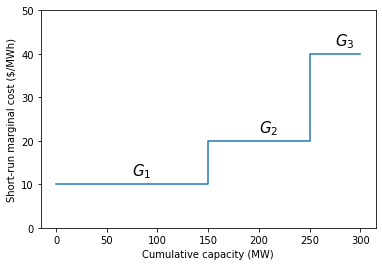

In [7]:
# Computing cumulative capacity for merit order plot
plot_data = df.T
plot_data['cumulative_capacity'] = plot_data['max_power'].cumsum()

# Creating figure and extracting data
fig, ax = plt.subplots()
x, y = list(plot_data['cumulative_capacity'].values), list(plot_data['cost'].values)
x = [0] + x
y = [y[0]] + y
ax.step(x, y)

# Formatting axes
ax.set_ylim(0, 50)
ax.text(75, 12, '$G_{1}$', fontsize=15)
ax.text(200, 22, '$G_{2}$', fontsize=15)
ax.text(275, 42, '$G_{3}$', fontsize=15)
ax.set_xlabel('Cumulative capacity (MW)')
ax.set_ylabel('Short-run marginal cost (\$/MWh)')

Now let's examine our model results by plotting generator output for each demand scenario.

Text(0.5, 0, 'Demand (MW)')

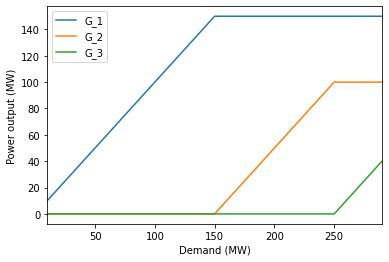

In [8]:
ax = df_r.set_index('DEMAND').plot()
ax.set_ylabel('Power output (MW)')
ax.set_xlabel('Demand (MW)')

At low demand only $G_{1}$ is used because it's the cheapest. Once $G_{1}$ is at max capacity, $G_{2}$ starts to be utilised, because it's the next cheapest generator in the merit order. Only when demand is high will $G_{3}$ be used as it's the most expensive generator.

## Summary
This notebook has gone through the basics of installing and using Pyomo. Optimisation modelling is an extremely powerful tool, especially when integrated within a high-level programming language like Python. We can organise our data, run scenarios, and analyse results using the same language. More sophisticated workflows can easily be created e.g. use of machine learning packages such as tensorflow, or statistical modelling packages like statsmodels.

The great thing about Pyomo is it's open-source. It provides a framework for expressing your optimisation problem which can then be interpreted by different solvers (for which you may need a license). You can learn more about it by looking at the docs: https://pyomo.readthedocs.io/en/stable/ or reading the book: 

Hart, W.E., Laird, C., Watson, J.P., Woodruff, D.L., Pyomo -- Optimization Modeling in Python, Springer, 2017